In [1]:
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
REGION_NAMES = ['GRASS', 'SIDEWALK', 'BUILDING', 'GRAVEL']

In [3]:
def plot_images(image_list, title_list=[], grid='off'):
    fig, axes = plt.subplots(nrows=1, ncols=len(image_list), figsize=(10*len(image_list), 10*1))
    if len(image_list) == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        ax.imshow(cv2.cvtColor(image_list[i], cv2.COLOR_BGR2RGB))
        if len(title_list) > 0:
            ax.set_title(title_list[i])
        ax.axis(grid)

In [4]:
def get_mission_file_path(mission_number):
    return '..\\missions\\mission_' + str(mission_number) + '\\mission_' + str(mission_number) + '_'

In [5]:
def get_aligned_region_and_sample_image(mission_number, region_name):
    region = np.load(get_mission_file_path(mission_number) + 'region_aligned_image_' + region_name + '.npy')
    sample = np.load(get_mission_file_path(mission_number) + 'sample_aligned_image_' + region_name + '.npy')
    return region, sample

# Start

In [6]:
# select mission
mission_number = 2

# load region
region, sample = get_aligned_region_and_sample_image(mission_number, 'GRASS')

H, W, _ = region.shape
print(H, W)

607 528


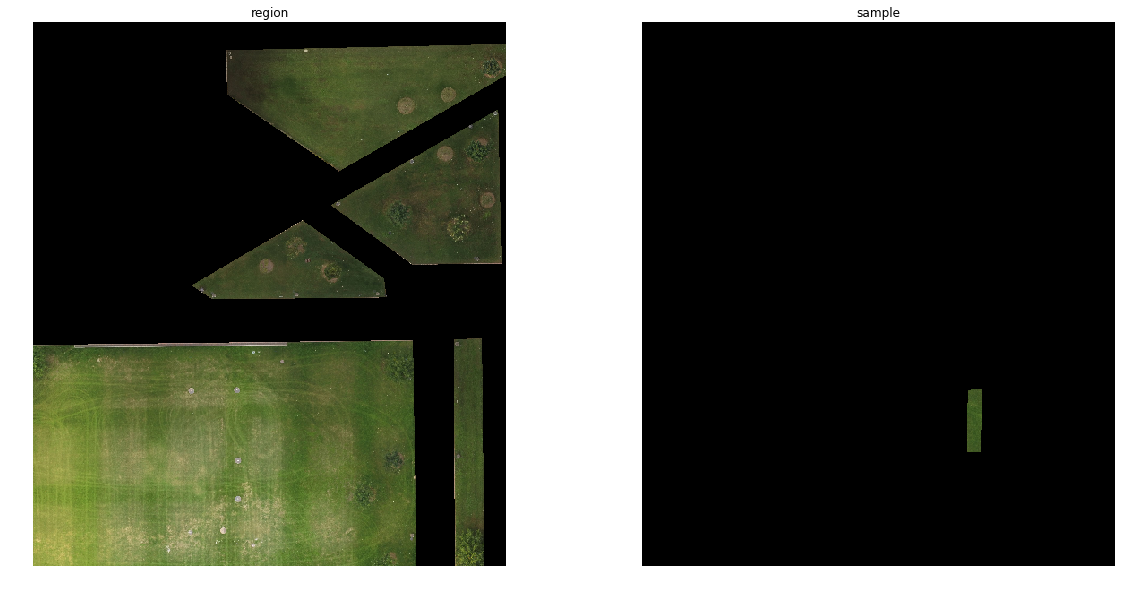

In [7]:
plot_images([region, sample], ['region', 'sample'])

# Detect Anomalies

In [8]:
region_mask = region != [0, 0, 0]
region_mask = region_mask.astype(np.uint8)*255
region_mask = region_mask[:, :, 0]

sample_mask = sample != [0, 0, 0]
sample_mask = sample_mask.astype(np.uint8)*255
sample_mask = sample_mask[:, :, 0]

print(region_mask.shape)
print(sample_mask.shape)

(607, 528)
(607, 528)


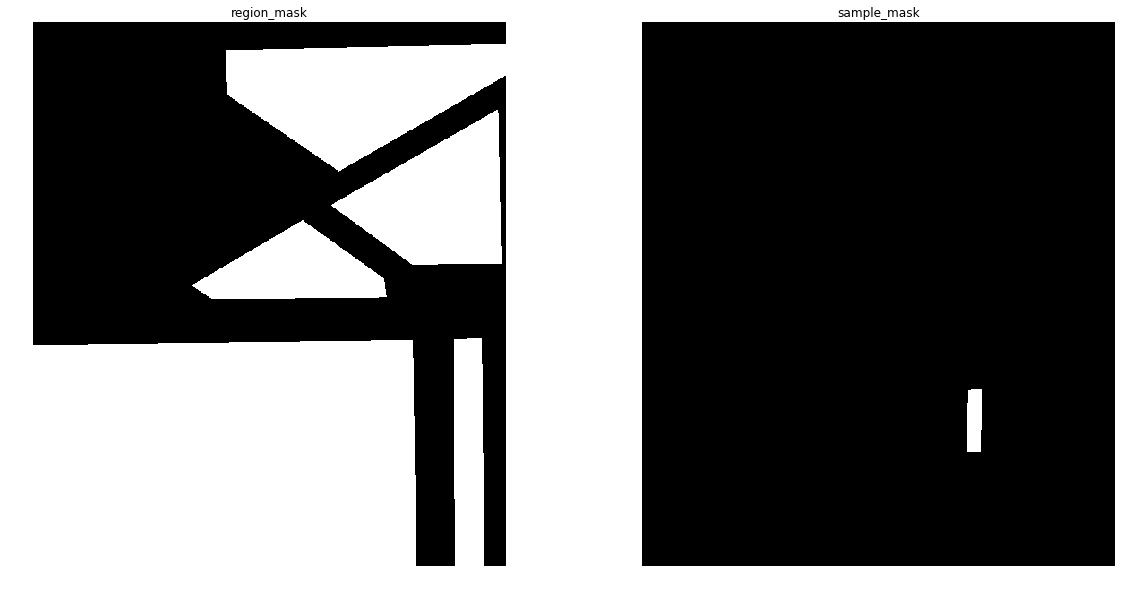

In [9]:
plot_images([region_mask, sample_mask], ['region_mask', 'sample_mask'])

In [10]:
# get pixel mean and covariance

sample_mask_bool = np.bool_(sample_mask)

pixel_mean = [np.mean(sample[sample_mask_bool, 0]), np.mean(sample[sample_mask_bool, 1]), np.mean(sample[sample_mask_bool, 2])]
print(pixel_mean)

pixel_variance = [np.var(sample[sample_mask_bool, 0]), np.var(sample[sample_mask_bool, 1]), np.var(sample[sample_mask_bool, 2])]
print(pixel_variance)

pixel_covariance = np.cov([sample[sample_mask_bool, 0], sample[sample_mask_bool, 1], sample[sample_mask_bool, 2]], rowvar=True)
print(pixel_covariance)

[35.904893813481074, 90.57802400738689, 65.56694367497691]
[17.644694425474192, 33.893035061288835, 36.249211988517246]
[[17.66100191 18.47831467 21.58908983]
 [18.47831467 33.92435949 29.32448545]
 [21.58908983 29.32448545 36.28271403]]


non zero pixels: 173182.0
-1.9215347682378408 11.7369618987297
0.0 13.65849666696754
0.0 255.0


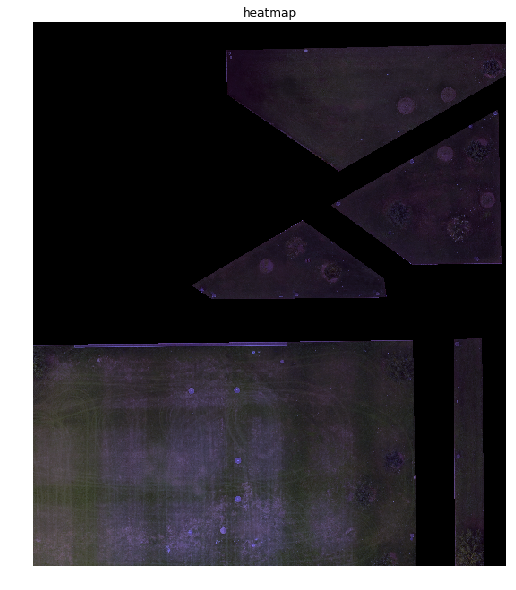

In [11]:
print('non zero pixels:', np.sum(region_mask)/255)
region_mask_bool = np.bool_(region_mask)

heatmap = np.zeros((H, W, 3))
heatmap[region_mask_bool, :] = region[region_mask_bool, :] - pixel_mean
heatmap[region_mask_bool, :] = heatmap[region_mask_bool, :] / pixel_variance
print(np.min(heatmap), np.max(heatmap))

heatmap[region_mask_bool, :] = heatmap[region_mask_bool, :] - np.min(heatmap)
print(np.min(heatmap), np.max(heatmap))
scale = 255/np.max(heatmap)
heatmap[region_mask_bool, :] = heatmap[region_mask_bool, :]*scale
print(np.min(heatmap), np.max(heatmap))


heatmap = heatmap.astype(np.uint8)
# heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)
# print(np.min(heatmap), np.max(heatmap))

plot_images([heatmap], ['heatmap'])

In [12]:
import seaborn as sb

sb.heatmap(heatmap)

ValueError: Must pass 2-d input

In [ ]:
print(np.min(px_diff))
print(np.max(px_diff))

In [ ]:
px_diff = px_diff.reshape(())

In [ ]:
print(512*568)